In [1]:
 !pip install fastkaggle timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.0/510.0 kB 2.4 MB/s eta 0:00:00


In [2]:
import timm
import numpy as np, pandas as pd 
from fastai.vision.all import *
from fastkaggle import *
from fastcore.parallel import *

In [3]:
comp = 'paddy-disease-classification'
path =setup_comp(comp)

In [4]:
df = pd.read_csv(path/'train.csv',index_col='image_id')

In [5]:
def get_variety(p): return df.loc[p.name, 'variety']

In [6]:
blocks = [ImageBlock, CategoryBlock, CategoryBlock]

In [7]:
trn_path = path/'train_images'

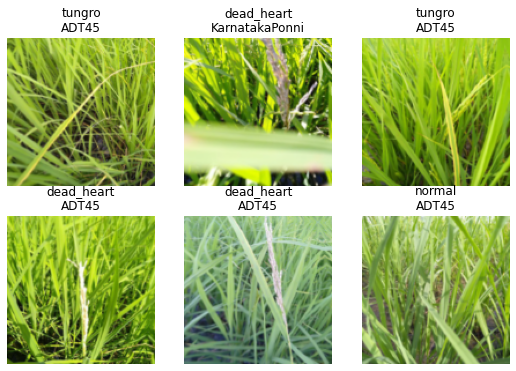

In [8]:
dls = DataBlock(blocks = blocks , n_inp = 1, 
                splitter = RandomSplitter(valid_pct = 0.2,seed=42),
                get_items = get_image_files, get_y= [parent_label,get_variety],
                item_tfms = Resize(192,method= 'squish'),
                batch_tfms = aug_transforms(size=128, min_scale= 0.75)).dataloaders(trn_path)

dls.show_batch(max_n=6)

In [9]:
# for single vraible prediction
def disease_err(inp,disease,variety): return error_rate(inp,disease)
def disease_loss(inp,disease,variety): return F.cross_entropy(inp,disease)

In [10]:
#for multiple variable prediction

In [11]:
def disease_loss(inp,disease,variety): return F.cross_entropy(inp[:,:10],disease)
def variety_loss(inp,disease,variety): return F.cross_entropy(inp[:,10:],variety)


In [12]:
def combine_loss(inp,disease,variety): return disease_loss(inp,disease,variety)+variety_loss(inp,disease,variety)


In [13]:
def disease_err(inp,disease,variety): return error_rate(inp[:,:10],disease)
def variety_err(inp,disease,variety): return error_rate(inp[:,10:],variety)

err_metrics = (disease_err,variety_err)

In [14]:
all_metrics = err_metrics+(disease_loss,variety_loss)

In [15]:
arch = 'convnext_small_in22k'
lr = 0.01

In [16]:
learn = vision_learner(dls, arch, loss_func=disease_loss, metrics=disease_err, n_out=10).to_fp16()


Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_small_22k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_small_22k_224.pth


In [17]:
learn.fine_tune(5, lr)

epoch,train_loss,valid_loss,disease_err,time
0,1.245402,0.990958,0.288323,02:00


epoch,train_loss,valid_loss,disease_err,time
0,0.648413,0.426693,0.146564,01:50
1,0.489309,0.272012,0.080250,01:51
2,0.318642,0.178494,0.056223,01:51
3,0.184884,0.135954,0.037001,01:52
4,0.143979,0.123620,0.032677,01:51


In [18]:
learn2 = vision_learner(dls, arch, loss_func=combine_loss, metrics=all_metrics, n_out=20).to_fp16()

In [19]:
learn2.fine_tune(5, lr)


epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,2.325671,1.155936,0.239308,0.135031,0.753162,0.402775,01:44


epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,1.029862,0.553814,0.129745,0.052379,0.385071,0.168743,01:51
1,0.794131,0.448779,0.100432,0.046132,0.301641,0.147137,01:51
2,0.494238,0.346246,0.088900,0.020663,0.274411,0.071835,01:50
3,0.290250,0.181788,0.036521,0.016819,0.129240,0.052547,01:51
4,0.204335,0.169805,0.036040,0.013455,0.122271,0.047534,01:51
